In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    %matplotlib inline
    
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
        

In [2]:
import pandas as pd
import os
import time
import numpy as np
import io
import requests
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

/home/iit/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
# Read MFCCs feature CSV file of audio of 100ms block

path="./project_mani"
#filename=os.path.join(path,"5class_100ms_file.csv")
#filename=os.path.join(path,"/home/iit/Desktop/project_mani/5classfet1.csv")
df=pd.read_csv("5class.csv")
df.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12', 'Label']
filename_write = os.path.join(path,"/home/iit/Manikanta/5class_write.csv")
#df=pd.read_csv(filename)
df.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,Label
0,-5.134120,22.534925,16.256354,15.571196,6.151718,10.189238,3.403501,5.576244,2.865339,1.756562,2.039639,0.308196,-0.069477,AC
1,-5.729284,18.445406,27.355768,29.713338,5.136650,6.819951,-1.589000,2.541730,1.910421,0.585029,2.101978,0.280134,-0.125808,AC
2,-4.808883,24.352262,25.142641,19.897518,4.414094,8.809319,-0.032421,1.812527,1.582176,-0.045355,1.088389,0.269761,-0.092001,AC
3,-4.543803,24.764735,28.873515,18.804799,2.090060,6.575556,1.366874,2.194397,5.139603,0.865666,0.428243,0.411056,-0.036403,AC
4,-5.426780,21.955622,23.657540,19.045338,3.968842,7.702331,3.959141,1.370562,5.936281,0.764971,0.784953,0.279222,0.038844,AC


In [7]:
# Shuffle
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)


In [8]:
# Encode to a 2D matrix for training
Label=encode_text_index(df,'Label')
print("Labelling is:{}".format(Label))

############################################################################################

# Sperating Independent variable and Target Variable
x,y=to_xy(df,'Label')

Labelling is:['AC' 'CRYING' 'FAN' 'SPEECH' 'TV']


/home/iit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [9]:
# Keep a 20% holdout
x_main, x_holdout, y_main, y_holdout = train_test_split(    
    x, y, test_size=0.20) 

In [10]:
print("Shape of x : {}".format(x.shape))
print("Shape of y : {}".format(y.shape))
print("Shape of x_main : {}".format(x_main.shape))
print("Shape of x_holdout : {}".format(x_holdout.shape))
print("Shape of y_main : {}".format(y_main.shape))
print("Shape of y_holdout : {}".format(y_holdout.shape))

Shape of x : (724498, 13)
Shape of y : (724498, 5)
Shape of x_main : (579598, 13)
Shape of x_holdout : (144900, 13)
Shape of y_main : (579598, 5)
Shape of y_holdout : (144900, 5)


In [12]:
# Cross-validate
kf = KFold(5)
epochs=30
oos_y = []
oos_pred = []
fold = 0
plot_loss = np.empty ((0,epochs))
plot_acc = np.empty ((0,epochs))
for train, test in kf.split(x_main):
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train = x_main[train]
    y_train = y_main[train]
    x_test = x_main[test]
    y_test = y_main[test]
#####################################################################################    
# Training 
# Fully Connected Neural Network Model    
    model = Sequential()
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) # Hidden 1
    model.add(Dense(25, activation='relu')) # Hidden 2
    model.add(Dense(12, activation='relu')) # Hidden 3
    model.add(Dense(y.shape[1],activation='softmax')) # Output
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto') 
    checkpointer = ModelCheckpoint(filepath="best_weights_myFNN.hdf5",
                               verbose=2,
                               save_best_only=True) # save best model

    start_time = time.time()
    history=model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],
                      verbose=0,batch_size=1024,epochs=epochs)
    
    #################################################################################
    ## Testing 
    
    pred = model.predict(x_test)
    
    oos_y.append(y_test)
    pred = np.argmax(pred,axis=1) # raw probabilities to chosen class (highest probability)
    oos_pred.append(pred)
    
#############################################################################################
    
    # Measure this fold's accuracy
    y_compare = np.argmax(y_test,axis=1) # For accuracy calculation
    score = metrics.accuracy_score(y_compare, pred)
    print("Fold score (accuracy): {}".format(score))
    
#######################
    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(hms_string(elapsed_time))) 
    
####################################################################################################

    ###############################################
    loss = history.history['loss']
    #plt.plot(epochs,loss,label=='Training loss')
    acc = history.history['acc']
    plot_loss = np.append (plot_loss, [loss],axis=0)
    plot_acc = np.append (plot_acc, [acc],axis=0)
    ###############################################
    cm = confusion_matrix(y_compare,pred)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)
    ##############################################



# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
oos_y_compare = np.argmax(oos_y,axis=1) # For accuracy calculation

score = metrics.accuracy_score(oos_y_compare, oos_pred)
print("Final score (accuracy): {}".format(score))  

#######################################################################################################    

# Write the cross-validated prediction
oos_y = pd.DataFrame(oos_y)
oos_pred = pd.DataFrame(oos_pred)
oosDF = pd.concat( [df, oos_y, oos_pred],axis=1 )
oosDF.to_csv(filename_write,index=False)

#####################################################################

model.summary()

Fold #1
Fold score (accuracy): 0.9952294685990338
Elapsed time: 0:01:19.69
Confusion matrix, without normalization
[[22806     1   132     3    35]
 [    0 23120     0     1     3]
 [  231     0 23064     6     5]
 [   13     4     9 22954    17]
 [   39    19     7    28 23423]]
Fold #2
Fold score (accuracy): 0.9950138026224983
Elapsed time: 0:01:20.25
Confusion matrix, without normalization
[[22980     0   210     1    22]
 [    0 22853     1     0     1]
 [  226     0 23070     4     4]
 [    7     5     5 22715    27]
 [   32    20     6     7 23724]]
Fold #3
Fold score (accuracy): 0.9945824706694272
Elapsed time: 0:01:21.49
Confusion matrix, without normalization
[[22773     0   134     1    60]
 [    0 23062     0     0     5]
 [  309     0 23211     2     4]
 [   16     3    14 23031    25]
 [   21    12     8    14 23215]]
Fold #4
Epoch 00030: early stopping
Fold score (accuracy): 0.9945220369395871
Elapsed time: 0:01:22.33
Confusion matrix, without normalization
[[22925     0 

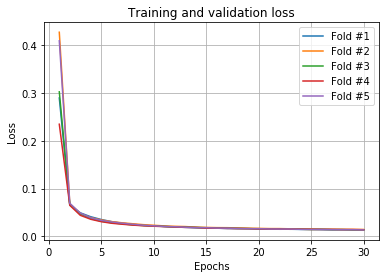

In [13]:
plot_loss_graph = plot_loss
itr=range(1,(epochs+1))
for i in range(1,fold+1):
    plt.plot(itr,plot_loss_graph[i-1],label="Fold #{}".format(i))
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig("mani_5C_loss.eps")
plt.savefig("mani_5class_loss.png",dpi=150)
plt.show()

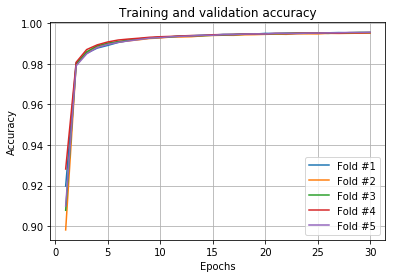

In [14]:
plt.clf()
plot_acc_graph = plot_acc
itr=range(1,(epochs+1))
for i in range(1,fold+1):
    plt.plot(itr,plot_acc_graph[i-1],label="Fold #{}".format(i))
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig("mani_k-fold_acc.eps",dpi=150)
plt.savefig('mani_k-fold_acc.png',dpi=150)
plt.show()

In [23]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='my_mani.png', show_shapes=True, show_layer_names=True)

Populating the interactive namespace from numpy and matplotlib


/home/iit/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cm', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


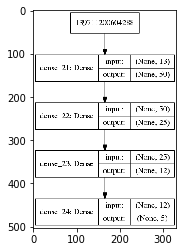

In [24]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('my_mani.png')
imgplot = plt.imshow(img)
plt.show()
from PIL import Image
image = Image.open('my_mani.png')
image.show()


In [15]:
## Turn off the scintific notation 
np.set_printoptions(suppress=True)

In [16]:
# Write the cross-validated prediction 
holdout_pred = model.predict(x_holdout)

In [17]:
score = metrics.log_loss(y_holdout, holdout_pred)
print("Log loss score of Holdout data: {}".format(score))

Log loss score of Holdout data: 0.015383495537958218


In [18]:
# Measure accuracy
holdout_pred = model.predict(x_holdout)
holdout_pred = np.argmax(holdout_pred, axis=1)
y_holdout_compare = np.argmax(y_holdout, axis=1)
score = metrics.accuracy_score(y_holdout_compare, holdout_pred)
print("Holdout accuracy: {}".format(score))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Holdout accuracy: 0.9953002070393375
Elapsed time: 0:01:47.61


Confusion matrix, without normalization
[[28825     0   226     2    54]
 [    0 28746     0     1     0]
 [  237     3 28569     7     7]
 [   14     3    10 28646    17]
 [   27    25     7    41 29433]]


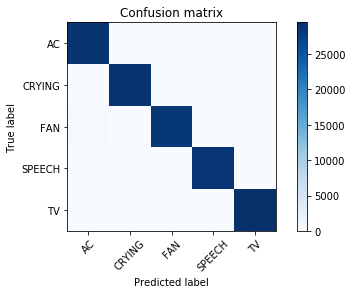

In [19]:


# Compute confusion matrix
cm = confusion_matrix(y_holdout_compare, holdout_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, Label)
plt.savefig('cm_holdout_myFNN.png',dpi=150)

Normalized confusion matrix
[[0.99 0.   0.01 0.   0.  ]
 [0.   1.   0.   0.   0.  ]
 [0.01 0.   0.99 0.   0.  ]
 [0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   1.  ]]


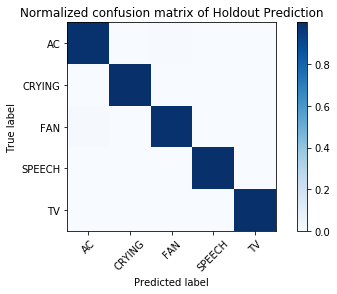

In [20]:
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, Label, title='Normalized confusion matrix of Holdout Prediction')
plt.savefig('norm_cm_holdout_myFNN.png',dpi=150)
plt.show()

In [21]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_holdout_compare, holdout_pred))  
print(classification_report(y_holdout_compare, holdout_pred))

[[28825     0   226     2    54]
 [    0 28746     0     1     0]
 [  237     3 28569     7     7]
 [   14     3    10 28646    17]
 [   27    25     7    41 29433]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99     29107
          1       1.00      1.00      1.00     28747
          2       0.99      0.99      0.99     28823
          3       1.00      1.00      1.00     28690
          4       1.00      1.00      1.00     29533

avg / total       1.00      1.00      1.00    144900



In [22]:
[[C1,E1,N1,S1,V1],[C2,E2,N2,S2,V2],[C3,E3,N3,S3,V3],[C4,E4,N4,S4,V4],[C5,E5,N5,S5,V5]]=cm

TP=(cm[0][0]+cm[1][1]+cm[2][2]+cm[3][3]+cm[4][4])
TN=(cm[0][0]+cm[1][1]+cm[2][2]+cm[3][3]+cm[4][4])
FP=np.sum(cm)-TP
FN=FP


Acc=(cm[0][0]+cm[1][1]+cm[2][2]+cm[3][3]+cm[4][4])/np.sum(cm)
print("Overall Accuracy: ",Acc*100)

Pr=(TP)/(TP+FP)
print("Precision: ",Pr*100)

Se=(TP)/(TP+FN)
print("Sensitivity/Recall: ",Se*100)

Sp=(TN)/(TN+FP)
print("Specificity: ",Sp*100)

ER=1-Acc
print("Error Rate: ",100*ER)

F_score = 2*TP /(2*TP + FP + FN)
print("F1-Score: ",F_score*100)

Overall Accuracy:  99.53002070393376
Precision:  99.53002070393376
Sensitivity/Recall:  99.53002070393376
Specificity:  99.53002070393376
Error Rate:  0.46997929606624744
F1-Score:  99.53002070393376


In [20]:
model.save('manikanta_FeedforwardNN_5class.h5')


elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Elapsed time: 0:02:49.56


In [26]:
df1=pd.read_csv('ac_1.csv')
df1.columns=['MFCC0', 'MFCC1','MFCC2','MFCC3','MFCC4','MFCC5','MFCC6','MFCC7','MFCC8', 'MFCC9', 'MFCC10' ,'MFCC11', 'MFCC12']
df1.head()

,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12
0,-4.768194,34.031533,17.272106,13.455052,4.734985,3.266335,-0.144751,-0.208921,-0.469237,0.421284,-0.114803,-0.237166,0.269319
1,-4.757876,32.552546,17.127382,12.057852,4.428186,3.726634,1.710152,0.551984,-1.204261,-0.723768,-0.446487,-0.312606,0.329525
2,-4.603864,31.965787,15.760231,13.788702,5.945601,6.304809,2.731478,2.311371,-0.055208,0.147039,-0.571475,-0.146211,0.148147
3,-4.583379,32.728263,20.435069,13.349465,7.721975,4.465763,2.096007,0.176928,-0.435706,-0.117059,0.019186,0.023602,0.044150
4,-4.773001,43.643621,26.089989,6.452514,7.704668,3.460699,3.486486,1.056610,-0.188047,-0.897772,-0.213563,-0.037604,0.109381


In [30]:
his=model.predict(df1)
his.shape


(36191, 5)

In [31]:
test_pred = np.argmax(his, axis=1)
test_pred[150:380]

array([3, 0, 0, 0, 3, 3, 3, 0, 3, 0, 2, 2, 0, 0, 0, 0, 0, 3, 0, 3, 0, 2,
       0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 0, 3, 0, 2, 0, 0, 3, 3, 2, 3, 2,
       0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 3, 0, 3, 3, 2, 2, 3, 0, 0,
       0, 2, 2, 2, 0, 3, 3, 3, 0, 0, 0, 3, 2, 2, 0, 0, 0, 3, 3, 2, 3, 3,
       3, 0, 3, 0, 0, 3, 0, 3, 0, 2, 0, 0, 0, 0, 0, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 0, 0, 0, 3, 2, 2, 0, 3, 0, 0, 3, 0, 2, 0, 0, 0, 0, 3, 0, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 3, 0, 3, 0, 3, 0,
       2, 0, 3, 0, 3, 3, 0, 2, 0, 3, 0, 0, 3, 0, 0, 2, 3, 3, 0, 0, 3, 0,
       3, 3, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 3, 0, 0, 0, 2, 3,
       3, 0, 2, 0, 0, 3, 0, 3, 0, 0])

In [32]:
sum(test_pred==0)

17144

In [34]:
x=17144/36191
print('Accuracy is for testing with new environment data of AC:',x)

Accuracy is for testing with new environment data of AC: 0.4737089331601779


In [35]:
model.save('manikanta_100ms_5class.h5')

In [36]:
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Elapsed time: 0:12:53.86


In [28]:
model.save('my_FNN.h5')